In [1]:
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt  

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

#Filter for Data Analyst data
df_DA = df[df["job_title_short"] == "Data Analyst"].copy()

c:\Users\Frederick\anaconda3\envs\test_proyec\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


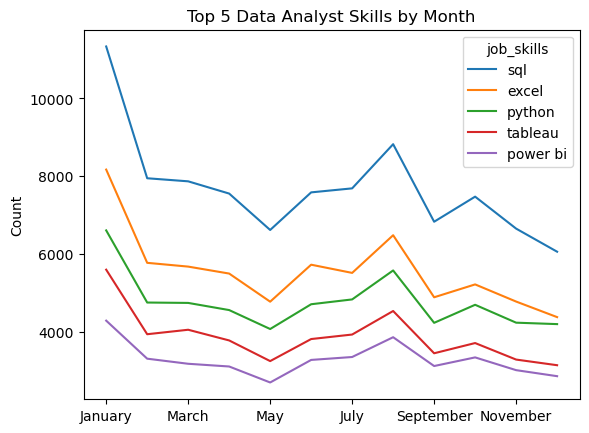

In [6]:
# create a new column for the month the job was posted
df_DA["job_posted_month_no"] = df_DA["job_posted_date"].dt.month

# explode the job_skills column and pivot
df_DA_explode = df_DA.explode("job_skills")
df_DA_pivot = df_DA_explode.pivot_table(index="job_posted_month_no", columns="job_skills", aggfunc="size", fill_value=0)

# sort the skills by count
df_DA_pivot.loc["Total"] = df_DA_pivot.sum()
df_DA_pivot = df_DA_pivot[df_DA_pivot.loc["Total"].sort_values(ascending=False).index]
df_DA_pivot = df_DA_pivot.drop("Total")

# convert the month number to month name
df_DA_pivot = df_DA_pivot.reset_index()
df_DA_pivot["job_posted_month"] = df_DA_pivot["job_posted_month_no"].apply(lambda x: pd.to_datetime(str(x), format='%m').strftime('%B'))
df_DA_pivot = df_DA_pivot.set_index("job_posted_month")
df_DA_pivot = df_DA_pivot.drop(columns="job_posted_month_no")

# Get the top 5 skills
df_DA_pivot.iloc[:, :5].plot(kind="line")

plt.title("Top 5 Data Analyst Skills by Month")
plt.xlabel("")
plt.ylabel("Count")
plt.show()

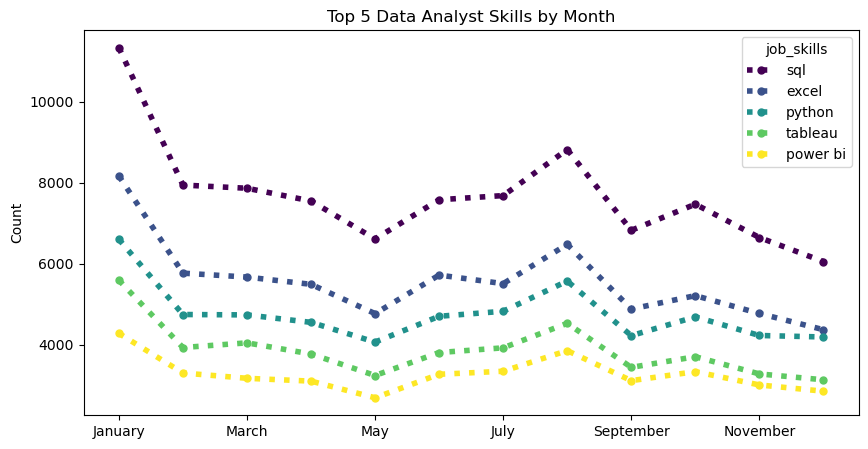

In [19]:
df_DA_pivot.iloc[:, :5].plot(
    kind="line",
    linewidth=4,
    linestyle=":", #options: "-", "--", "-.", ":"
    colormap="viridis", #options: viridis, plasma, inferno, magma, cividis
    marker="o", #options: "o", "x", "+", "s", "D"
    markersize=5,
    figsize=(10, 5)
)

plt.title("Top 5 Data Analyst Skills by Month")
plt.xlabel("")
plt.ylabel("Count")
plt.show()

In [25]:
df_exploded = df_DA.explode('job_skills')

skill_stats = df_exploded.groupby("job_skills").agg(
    skill_count=("job_skills", "count"),
    median_salary=("salary_year_avg", "median")
)

skills_stats = skill_stats.sort_values(by="skill_count", ascending=False).head(20)

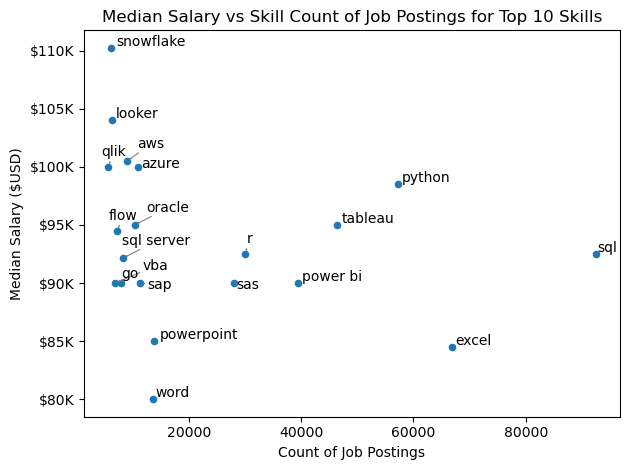

In [36]:
from adjustText import adjust_text

skills_stats.plot(kind="scatter", x="skill_count", y="median_salary")
plt.title("Median Salary vs Skill Count of Job Postings for Top 10 Skills")
plt.xlabel("Count of Job Postings")
plt.ylabel("Median Salary ($USD)")

texts = []
for i, txt in enumerate(skills_stats.index):
    texts.append(plt.text(skills_stats["skill_count"].iloc[i], skills_stats["median_salary"].iloc[i], txt))

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.8))

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f"${int(y/1000)}K"))

plt.tight_layout()
plt.show()